# Инициализация

**Добрый день! Очень нужно ревью. Мне кажется, я что-то принципиально важное не понимаю. Несколько дней пытался увеличить метрики, но не сдвинулся ни на шаг.**

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import io
from dotenv import load_dotenv
import boto3
from botocore.exceptions import ClientError
from botocore.config import Config
import gc
from datetime import datetime
import implicit
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import scipy
import pickle
from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.float_format', '{:.2f}'.format)

c:\Files\AI\MLE\mle-project-sprint-4-v001\mle4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
# Загружаем таблицу с треками
df_tracks = pd.read_parquet("data/tracks.parquet")

# Загружаем таблицу с именами (треки, альбомы, артисты, жанры)
df_catalog = pd.read_parquet("data/catalog_names.parquet")

# Загружаем таблицу с фактами прослушиваний
df_interactions = pd.read_parquet("data/interactions.parquet")

# Быстрая проверка
print("Tracks:", df_tracks.shape)
print("Catalog:", df_catalog.shape)
print("Interactions:", df_interactions.shape)

display(df_tracks.head(), df_tracks.info())
display(df_catalog.head(), df_catalog.info())
display(df_interactions.head(), df_interactions.info())

Tracks: (1000000, 4)
Catalog: (1812471, 3)
Interactions: (222629898, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


None

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


None

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:

# Преобразуем started_at в datetime (если ещё не в формате datetime)
df_interactions['started_at'] = pd.to_datetime(df_interactions['started_at'])

# Минимальная и максимальная дата
min_date = df_interactions['started_at'].min()
max_date = df_interactions['started_at'].max()
print(f"Диапазон всех событий: {min_date} — {max_date}")

# Проверим, сколько событий до и после 16 декабря 2022
split_date = pd.to_datetime("2022-12-16")

# Процент событий до и после split_date
before_split = round(df_interactions[df_interactions['started_at'] < split_date].shape[0] / len(df_interactions), 2)
after_split  = round(df_interactions[df_interactions['started_at'] >= split_date].shape[0] / len(df_interactions), 2)

print(f"Событий до 16 декабря 2022: {before_split}")
print(f"Событий с 16 декабря 2022 и позже: {after_split}")

Диапазон всех событий: 2022-01-01 00:00:00 — 2022-12-31 00:00:00
Событий до 16 декабря 2022: 0.94
Событий с 16 декабря 2022 и позже: 0.06


In [ ]:
# # Срез данных за 2 месяца до разделения
# cutoff_date = pd.to_datetime("2022-10-16")
# df_interactions_recent = df_interactions[df_interactions['started_at'] > cutoff_date].copy()

# print(f"Было событий: {len(df_interactions):_}, осталось событий: {len(df_interactions_recent):_}")

# # Процент событий до и после split_date в последних 6 месяцах
# before_split = (df_interactions_recent['started_at'] < split_date).mean().round(2)
# after_split  = (df_interactions_recent['started_at'] >= split_date).mean().round(2)

# print(f"Событий до 16 декабря 2022: {before_split}")
# print(f"Событий с 16 декабря 2022 и позже: {after_split}")

In [4]:
def inspect_df(df: pd.DataFrame, name: str):
    """
    Выводит базовую информацию о DataFrame:
    - размер
    - типы столбцов
    - количество и % пропусков
    - первые 5 строк
    """
    print(f"{name} — shape: {df.shape}")
    print(df.dtypes)
    
    missing_counts = df.isna().sum()
    missing_percent = (missing_counts / len(df) * 100).round(2)
    missing_summary = pd.DataFrame({
        'missing_count': missing_counts,
        'missing_percent': missing_percent
    })
    print("\nПропуски по столбцам:")
    display(missing_summary)   


In [5]:
inspect_df(df_tracks, "Tracks")


Tracks — shape: (1000000, 4)
track_id     int64
albums      object
artists     object
genres      object
dtype: object

Пропуски по столбцам:


,missing_count,missing_percent
track_id,0,0.00
albums,0,0.00
artists,0,0.00
genres,0,0.00


In [6]:
inspect_df(df_catalog, "Catalog")

Catalog — shape: (1812471, 3)
id       int64
type    object
name    object
dtype: object

Пропуски по столбцам:


,missing_count,missing_percent
id,0,0.00
type,0,0.00
name,0,0.00


In [7]:
inspect_df(df_interactions, "Interactions")

Interactions — shape: (222629898, 4)
user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

Пропуски по столбцам:


,missing_count,missing_percent
user_id,0,0.00
track_id,0,0.00
track_seq,0,0.00
started_at,0,0.00


In [8]:
def unknown_counts(df):
    """
    Проверяет, есть ли треки с пустыми списками или None в albums, artists, genres
    """
    cols = ['albums', 'artists', 'genres']
    for c in cols:
        cnt = df[c].apply(lambda x: x is None or len(x) == 0).sum()
        pct = (cnt / len(df) * 100).round(2)
        print(f"{c}: {cnt} треков ({pct}%) без данных")

unknown_counts(df_tracks)

# Удаляем треки с пустыми artists или genres
df_tracks_clean = df_tracks[
    df_tracks['artists'].apply(lambda x: len(x) > 0) &
    df_tracks['genres'].apply(lambda x: len(x) > 0)
].copy()

print(f"Было треков: {len(df_tracks):,}".replace(",", "_"))
print(f"Осталось треков: {len(df_tracks_clean):,}".replace(",", "_"))

albums: 18 треков (0.0%) без данных
artists: 15369 треков (1.54%) без данных
genres: 3687 треков (0.37%) без данных
Было треков: 1_000_000
Осталось треков: 980_977


# Выводы

**Интеракции (прослушивания)**

Всего: 222,629,898 событий.


**Треки (df_tracks)**

Всего треков: 1,000,000.

Пропусков по столбцам нет после очистки.

После удаления треков без исполнителя или жанра осталось 980,977 треков.

**Каталог (df_catalog)**

Всего записей: 1,812,471.

Некоторая часть треков не имеет данных по артистам (1.54%) и жанрам (0.37%), альбомов почти все есть (0.0% пропусков).



Данные почти полные, но есть небольшое число треков без артиста/жанра, которые мы удалили для чистоты.

После фильтрации получаем актуальные события за последние 6 месяцев и чистый каталог треков для построения рекомендаций.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

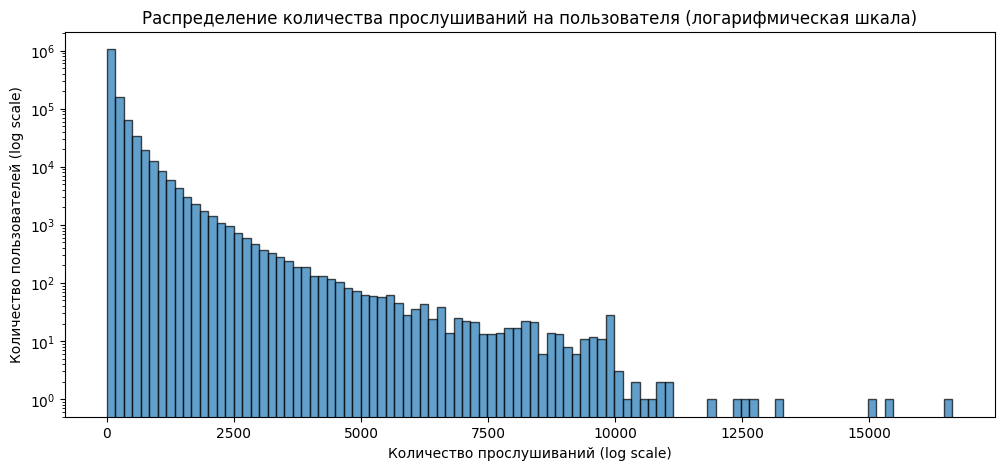

In [9]:
track_counts_per_user = df_interactions.groupby('user_id')['track_id'].count()

# Визуализация полного распределения (с логарифмической шкалой)
plt.figure(figsize=(12, 5))
# Используем log=True для оси X и Y
n, bins, patches = plt.hist(track_counts_per_user, bins=100, log=True, edgecolor='black', alpha=0.7)
plt.title("Распределение количества прослушиваний на пользователя (логарифмическая шкала)")
plt.xlabel("Количество прослушиваний (log scale)")
plt.ylabel("Количество пользователей (log scale)")
plt.show()

Наиболее популярные треки

In [10]:
popular_tracks = df_interactions['track_id'].value_counts().reset_index()
popular_tracks.columns = ['track_id', 'plays']
popular_tracks = popular_tracks.merge(df_catalog[df_catalog['type']=='track'][['id','name']],
                                      left_on='track_id', right_on='id', how='left')
popular_tracks = popular_tracks[['track_id','name','plays']]
print("Топ-10 популярных треков:")
popular_tracks.head(10)


Топ-10 популярных треков:


,track_id,name,plays
0,53404,Smells Like Teen Spirit,111062
1,33311009,Believer,106921
2,178529,Numb,101924
3,35505245,I Got Love,99490
4,65851540,Юность,86670
5,24692821,Way Down We Go,86246
6,32947997,Shape of You,85886
7,51241318,In The End,85244
8,795836,Shape Of My Heart,85042
9,45499814,Life,84748


Наиболее популярные жанры

In [11]:
# --- Подсчёт жанров через объединение по трекам без explode полного df_interactions ---

# Считаем сколько раз каждый трек прослушан
track_play_counts = df_interactions['track_id'].value_counts()

# Добавляем количество прослушиваний к df_tracks
df_tracks_counts = df_tracks.copy()
df_tracks_counts['plays'] = df_tracks_counts['track_id'].map(track_play_counts).fillna(0)

# Считаем количество прослушиваний для каждого жанра
# Разворачиваем только жанры с учётом количества plays
df_genres = df_tracks_counts[['genres', 'plays']].explode('genres')
popular_genres = df_genres.groupby('genres')['plays'].sum().reset_index()
popular_genres.columns = ['genre_id', 'plays']

# Добавляем названия жанров
genre_names = df_catalog[df_catalog['type']=='genre'][['id','name']]
popular_genres = popular_genres.merge(genre_names, left_on='genre_id', right_on='id', how='left')
popular_genres = popular_genres[['genre_id','name','plays']].sort_values('plays', ascending=False)

print("Топ-10 популярных жанров:")
popular_genres.head(10)

Топ-10 популярных жанров:


,genre_id,name,plays
10,11,pop,55578312
70,75,rap,37799821
95,102,allrock,31092013
19,20,ruspop,26626241
2,3,rusrap,25303695
63,68,electronics,20120981
15,16,dance,16291557
1,2,rusrock,13166147
13,14,rock,12772644
42,47,metal,12437375


Треки, которые никто не прослушал

In [ ]:
# # Считаем, какие треки имеют хотя бы одно прослушивание
# tracks_with_plays = df_interactions_recent['track_id'].unique()

# # Удаляем треки без прослушиваний
# df_tracks = df_tracks[df_tracks['track_id'].isin(tracks_with_plays)].copy()

# print(f"Осталось треков: {len(df_tracks):,}".replace(",", "_"))


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [12]:
# 1. Создаём словари по типам
artist_dict = df_catalog[df_catalog['type'] == 'artist'].set_index('id')['name'].to_dict()
genre_dict = df_catalog[df_catalog['type'] == 'genre'].set_index('id')['name'].to_dict()
track_dict = df_catalog[df_catalog['type'] == 'track'].set_index('id')['name'].to_dict()

# 2. Функция маппинга (как раньше)
def map_ids_to_names(id_list, name_dict):
    if id_list is None or len(id_list) == 0:
        return []
    return [name_dict.get(int(x), f"unknown_{x}") for x in id_list]

# 3. Формируем df_items
df_items = df_tracks_clean[['track_id', 'artists', 'genres']].copy()

# 4. Добавляем названия
df_items['track_name'] = df_items['track_id'].map(track_dict)  # ← новая строка!
df_items['artist_names'] = df_items['artists'].apply(lambda x: map_ids_to_names(x, artist_dict))
df_items['genre_names'] = df_items['genres'].apply(lambda x: map_ids_to_names(x, genre_dict))

# 5. Финальный порядок колонок
df_items = df_items[['track_id', 'track_name', 'artist_names', 'genre_names']]

# 6. Проверка
df_items.head(10)

,track_id,track_name,artist_names,genre_names
0,26,Complimentary Me,[Elizabeth & the Catapult],"[pop, folk]"
1,38,Momma's Boy,[Elizabeth & the Catapult],"[pop, folk]"
2,135,Atticus,[Noisettes],[pop]
3,136,24 Hours,[Noisettes],[pop]
4,138,Don't Upset The Rhythm (Go Baby Go),[Noisettes],[pop]
5,139,Wild Young Hearts,[Noisettes],[pop]
6,140,Sometimes,[Noisettes],[pop]
7,141,Never Forget You,[Noisettes],[pop]
8,143,Every Now And Then,[Noisettes],[pop]
9,144,Leave Me,[Scorpions],"[hardrock, allrock]"


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [15]:
# --- 1. Загружаем переменные окружения ---
load_dotenv()

aws_access_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = os.getenv("S3_BUCKET_NAME")

items_key = "recsys/data/items.parquet"
events_key = "recsys/data/events.parquet"

# --- 2. Создаём клиент S3 ---
s3_config = Config(
    region_name='ru-central1',
    signature_version='s3v4',
    s3={'addressing_style': 'path'}
)

s3 = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_access_key,
    config=s3_config
)

# --- 3. Вспомогательная функция: проверка существования файла в S3 ---
def file_exists_in_s3(bucket, key):
    try:
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False
        else:
            raise

# --- 4. Обработка items.parquet ---
local_items_path = "data/items.parquet"

# Локальное сохранение (только если нет)
if not os.path.exists(local_items_path):
    os.makedirs(os.path.dirname(local_items_path), exist_ok=True)
    df_items.to_parquet(local_items_path, index=False)
    print(f"✅ items.parquet сохранён локально: {os.path.abspath(local_items_path)}")
else:
    print("⏭️  items.parquet уже существует локально — пропускаем запись.")

# Загрузка в S3 (только если нет в облаке)
if not file_exists_in_s3(bucket_name, items_key):
    with open(local_items_path, 'rb') as f:
        s3.put_object(Bucket=bucket_name, Key=items_key, Body=f.read())
    print(f"📤 items.parquet загружен в s3://{bucket_name}/{items_key}")
else:
    print(f"⏭️  items.parquet уже существует в S3 — пропускаем загрузку.")

# --- 5. Обработка events.parquet ---
local_events_path = "data/events.parquet"

if not os.path.exists(local_events_path):
    os.makedirs(os.path.dirname(local_events_path), exist_ok=True)
    df_interactions.to_parquet(local_events_path, index=False)
    print(f"✅ events.parquet сохранён локально: {os.path.abspath(local_events_path)}")
else:
    print("⏭️  events.parquet уже существует локально — пропускаем запись.")

if not file_exists_in_s3(bucket_name, events_key):
    with open(local_events_path, 'rb') as f:
        s3.put_object(Bucket=bucket_name, Key=events_key, Body=f.read())
    print(f"📤 events.parquet загружен в s3://{bucket_name}/{events_key}")
else:
    print(f"⏭️  events.parquet уже существует в S3 — пропускаем загрузку.")

✅ items.parquet сохранён локально: c:\Files\AI\MLE\mle-project-sprint-4-v001\data\items.parquet
📤 items.parquet загружен в s3://s3-student-mle-20250704-4a1b0ab232-freetrack/recsys/data/items.parquet
✅ events.parquet сохранён локально: c:\Files\AI\MLE\mle-project-sprint-4-v001\data\events.parquet
📤 events.parquet загружен в s3://s3-student-mle-20250704-4a1b0ab232-freetrack/recsys/data/events.parquet


**Популярные треки:**

Топ-10 включает всемирно известные композиции: Smells Like Teen Spirit, Believer, Numb, I Got Love, Shape of You и др.

Наиболее прослушиваемый трек — Smells Like Teen Spirit (111 062 прослушиваний).

**Популярные жанры:**

Лидируют pop (55,5 млн), rap (37,8 млн), allrock (31,0 млн).

Русские жанры (ruspop, rusrap, rusrock) также присутствуют в топе.

**Треки без прослушиваний:**

Треков, которые никто не слушал, нет — все треки имеют хотя бы одно взаимодействие.

Подготовка данных для рекомендаций:

Созданы удобные словари id -> name для треков, альбомов, исполнителей и жанров.

Данные объединены в df_items с названиями треков, жанров, исполнителей и альбомов.

Данные о взаимодействиях сохранены как df_interactions.

**Сохранение и выгрузка:**

Локально сохранены файлы items.parquet и events.parquet.

Успешно загружены в S3 по пути recsys/data/.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [16]:
import psutil
print(f"RAM used: {psutil.virtual_memory().percent}%")
# Удаляем большие исходные данные
to_delete = [
    'df_tracks',
    'df_catalog',
    'df_interactions',
    'df_tracks_clean',
    'tracks_with_plays',
    'artist_dict',
    'genre_dict',
    'track_dict',
    'map_ids_to_names',
    'inspect_df',
    'unknown_counts',
    'before_split',
    'after_split',
    'items',
    'event'

]

for var in to_delete:
    if var in globals():
        del globals()[var]

print("✅ Ненужные переменные удалены")
import gc
gc.collect()
print("🧹 Сборка мусора выполнена")
print(f"RAM used: {psutil.virtual_memory().percent}%")


RAM used: 76.5%
✅ Ненужные переменные удалены
🧹 Сборка мусора выполнена
RAM used: 76.1%


# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [17]:
items = pd.read_parquet("data/items.parquet")
events = pd.read_parquet("data/events.parquet")

display(items.head())
events.head()


,track_id,track_name,artist_names,genre_names
0,26,Complimentary Me,[Elizabeth & the Catapult],"[pop, folk]"
1,38,Momma's Boy,[Elizabeth & the Catapult],"[pop, folk]"
2,135,Atticus,[Noisettes],[pop]
3,136,24 Hours,[Noisettes],[pop]
4,138,Don't Upset The Rhythm (Go Baby Go),[Noisettes],[pop]


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [19]:
# --- 1. Преобразуем даты ---
events["started_at"] = pd.to_datetime(events["started_at"])

# --- 2. Разделение по дате ---
split_date = pd.Timestamp("2022-12-16")
events_train = events[events["started_at"] < split_date].copy()
events_test = events[events["started_at"] >= split_date].copy()

print(f"Train events: {len(events_train):,}")
print(f"Test events: {len(events_test):,}")

# --- 3. Удаляем треки без прослушиваний ---
events_train = events_train[events_train["track_id"].notna()]
events_test = events_test[events_test["track_id"].notna()]

# --- 4. Фильтруем тест: только треки, которые есть в train ---
valid_track_ids = set(events_train["track_id"].unique())
events_test = events_test[events_test["track_id"].isin(valid_track_ids)]

# --- 5. Обновляем статистику ---
users_train = set(events_train["user_id"].unique())
users_test = set(events_test["user_id"].unique())
common_users = users_train & users_test

print(f"\n✅ После фильтрации:")
print(f"Train users: {len(users_train):,}")
print(f"Test users: {len(users_test):,}")
print(f"Users in both: {len(common_users):,}")
print(f"Train tracks: {events_train['track_id'].nunique():,}")
print(f"Test tracks: {events_test['track_id'].nunique():,}")

Train events: 208,731,252
Test events: 13,898,646

✅ После фильтрации:
Train users: 1,342,566
Test users: 783,510
Users in both: 752,855
Train tracks: 999,695
Test tracks: 594,021


In [20]:
test_track_ids = set(events_test['track_id'].unique())
item_track_ids = set(df_items['track_id'].unique())
missing_tracks = test_track_ids - item_track_ids
print(f"Треков в test, но нет в items: {len(missing_tracks)}")

Треков в test, но нет в items: 12262


In [21]:
# Получите track_id, которые есть в items (т.е. прошли очистку)
valid_track_ids = set(df_items['track_id'])

# Отфильтруйте train и test, оставив только валидные треки
events_train_clean = events_train[events_train['track_id'].isin(valid_track_ids)]
events_test_clean = events_test[events_test['track_id'].isin(valid_track_ids)]

print(f"Train events: было {len(events_train)}, стало {len(events_train_clean)}")
print(f"Test events: было {len(events_test)}, стало {len(events_test_clean)}")

Train events: было 208731252, стало 208334360
Test events: было 13896751, стало 13848266


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [22]:
# Пути
local_top_path = "data/top_popular.parquet"
s3_top_key = "recsys/recommendations/top_popular.parquet"

# Функция проверки наличия в S3
def file_exists_in_s3(bucket, key):
    try:
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except ClientError as e:
        return False

# Проверяем: есть ли файл и локально, и в S3
local_exists = os.path.exists(local_top_path)
s3_exists = file_exists_in_s3(bucket_name, s3_top_key)

if local_exists and s3_exists:
    print("⏭️  Файл top_popular.parquet уже существует локально и в S3 — расчёт пропущен.")
    top_100_with_names = pd.read_parquet(local_top_path)
else:
    print("Рассчитываем топ-100 популярных треков...")
    
    # --- Расчёт топ-100 ---
    track_popularity = (
        events_train_clean
        .groupby('track_id')
        .agg(
            users=('user_id', 'nunique'),
            play_count=('track_id', 'count')
        )
        .reset_index()
    )
    track_popularity = track_popularity.sort_values('users', ascending=False)
    top_100 = track_popularity.head(100).copy()
    
    top_100_with_names = top_100.merge(
        df_items[['track_id', 'track_name', 'artist_names', 'genre_names']],
        on='track_id',
        how='left'
    )
    
    # --- Сохранение локально ---
    os.makedirs(os.path.dirname(local_top_path), exist_ok=True)
    top_100_with_names.to_parquet(local_top_path, index=False)
    print(f"✅ Сохранено локально: {local_top_path}")
    
    # --- Загрузка в S3 ---
    with open(local_top_path, 'rb') as f:
        s3.put_object(Bucket=bucket_name, Key=s3_top_key, Body=f.read())
    print(f"📤 Загружено в S3: s3://{bucket_name}/{s3_top_key}")

# -------------------------------------------------
# ВЫВОД ПРИМЕРОВ (всегда)
# -------------------------------------------------
print("\n" + "="*80)
print("Топ-3 популярных треков:")
print("="*80)

for idx, row in top_100_with_names.head(3).iterrows():
    track_name = row['track_name'] or "Неизвестно"
    artist = ", ".join(row['artist_names']) if isinstance(row['artist_names'], list) else str(row['artist_names'])
    genres = ", ".join(row['genre_names']) if isinstance(row['genre_names'], list) else str(row['genre_names'])
    users = row['users']
    
    print(f"{idx+1}. {track_name}")
    print(f"    Исполнитель: {artist}")
    print(f"    Жанры: {genres}")
    print(f"    Уникальных слушателей: {users:,}")
    print("-" * 80)

Рассчитываем топ-100 популярных треков...
✅ Сохранено локально: data/top_popular.parquet
📤 Загружено в S3: s3://s3-student-mle-20250704-4a1b0ab232-freetrack/recsys/recommendations/top_popular.parquet

Топ-3 популярных треков:
1. Smells Like Teen Spirit
    Исполнитель: Nirvana
    Жанры: alternative, rock, allrock
    Уникальных слушателей: 110,026
--------------------------------------------------------------------------------
2. Believer
    Исполнитель: Imagine Dragons
    Жанры: rock, allrock
    Уникальных слушателей: 101,076
--------------------------------------------------------------------------------
3. Numb
    Исполнитель: Linkin Park
    Жанры: numetal, metal
    Уникальных слушателей: 100,866
--------------------------------------------------------------------------------


In [23]:
top_100_with_names

,track_id,users,play_count,track_name,artist_names,genre_names
0,53404,110026,110026,Smells Like Teen Spirit,[Nirvana],"[alternative, rock, allrock]"
1,33311009,101076,101076,Believer,[Imagine Dragons],"[rock, allrock]"
2,178529,100866,100866,Numb,[Linkin Park],"[numetal, metal]"
3,35505245,95523,95523,I Got Love,"[Miyagi & Эндшпиль, Рем Дигга]","[rusrap, rap]"
4,24692821,84153,84153,Way Down We Go,[KALEO],[indie]
...,...,...,...,...,...,...
95,68562711,47588,47588,Сияй,[Ramil'],"[pop, ruspop]"
96,75944934,47536,47536,Astronaut In The Ocean,[Masked Wolf],"[foreignrap, rap]"
97,75642961,47438,47438,Венера-Юпитер,[Ваня Дмитриенко],"[pop, ruspop]"
98,29175370,47320,47320,Рапапам,"[9 грамм, Miyagi & Эндшпиль]","[rusrap, rap]"


In [24]:
K = 100
top_k_tracks = set(top_100_with_names['track_id'].head(K))

# --- Precision и Recall ---
# Отбираем события из test, где трек в топ-K
test_hits = events_test_clean[events_test_clean['track_id'].isin(top_k_tracks)]

# hits на пользователя
user_hits = test_hits.groupby('user_id')['track_id'].nunique()

# количество релевантных треков на пользователя
user_relevant_counts = events_test_clean.groupby('user_id')['track_id'].nunique()

hits_total = user_hits.sum()
relevant_total = user_relevant_counts.sum()

precision = hits_total / (len(user_relevant_counts) * K)
recall = hits_total / relevant_total

# --- Coverage ---
coverage = len(top_k_tracks) / len(df_items)

# --- Novelty (вариант 2: новые треки относительно train) ---
# для каждого юзера считаем сколько топ-K он уже слушал
train_in_topk = events_train_clean[events_train_clean['track_id'].isin(top_k_tracks)]
user_train_in_topk = train_in_topk.groupby('user_id')['track_id'].nunique()

# unseen = K - (сколько слушал)
novelty_vals = 1 - (user_train_in_topk.reindex(user_relevant_counts.index, fill_value=0) / K)
novelty = novelty_vals.mean()

# --- Вывод ---
print("📊 Top-Popular Metrics:")
print(f"Precision@{K}:  {precision:.4f}")
print(f"Recall@{K}:     {recall:.4f}") 
print(f"Coverage:       {coverage:.2%}")
print(f"Novelty@{K}:    {novelty:.4f}")

📊 Top-Popular Metrics:
Precision@100:  0.0045
Recall@100:     0.0254
Coverage:       0.01%
Novelty@100:    0.9550


# Персональные

Рассчитаем персональные рекомендации.

In [25]:
def prepare_als_data_fast(events_df):
    # Быстрая индексация через pd.factorize
    user_idx, user_codes = pd.factorize(events_df['user_id'])
    track_idx, track_codes = pd.factorize(events_df['track_id'])
    
    # Двоичная матрица взаимодействий
    data = np.ones(len(events_df), dtype=np.float32)
    
    user_item_matrix = csr_matrix((data, (user_idx, track_idx)),
                                  shape=(len(user_codes), len(track_codes)))
    
    # Словари для обратного преобразования
    user_to_idx = dict(zip(user_codes, range(len(user_codes))))
    track_to_idx = dict(zip(track_codes, range(len(track_codes))))
    idx_to_track = dict(zip(range(len(track_codes)), track_codes))
    
    return user_item_matrix, user_to_idx, track_to_idx, idx_to_track

# Применение
user_item_matrix, user_to_idx, track_to_idx, idx_to_track = prepare_als_data_fast(events_train_clean)
print(f"Размерность матрицы: {user_item_matrix.shape}")

# idx_to_track_arr нужен как массив для быстрого индексирования
idx_to_track_arr = np.array([track_id for idx, track_id in sorted(idx_to_track.items())], dtype=np.int32)

def csr_matrix_size_gb(mat):
    """Возвращает приблизительный размер csr_matrix в ГБ"""
    data_size = mat.data.nbytes
    indices_size = mat.indices.nbytes
    indptr_size = mat.indptr.nbytes
    total_bytes = data_size + indices_size + indptr_size
    return total_bytes / 1e9

size_gb = csr_matrix_size_gb(user_item_matrix)
print(f"Размер user_item_matrix: {size_gb:.2f} GB")

Размерность матрицы: (1342107, 980684)
Размер user_item_matrix: 1.67 GB


In [26]:
def train_als_model(user_item_matrix, factors=100, iterations=15, regularization=0.02):
    model = AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        regularization=regularization,
        random_state=42
    )
    
    # Обучаем модель
    model.fit(user_item_matrix)
    return model

# Обучение модели
als_model = train_als_model(user_item_matrix)
print("✅ ALS модель обучена")

c:\Files\AI\MLE\mle-project-sprint-4-v001\mle4\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Files\AI\MLE\mle-project-sprint-4-v001\mle4\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
100%|██████████| 15/15 [02:33<00:0

✅ ALS модель обучена


In [27]:
def generate_personal_recommendations(model, user_item_matrix, user_to_idx, idx_to_track,
                                           k=500, batch_size=50000, progress=True):
    """
    Быстрая и надёжная генерация персональных рекомендаций.
    - model.recommend принимает индексы пользователей (0..n-1)
    - user_to_idx: dict {user_id -> user_idx}
    - idx_to_track: dict {track_idx -> track_id}
    Возвращает DataFrame ['user_id','track_id','score']
    """
    # --- Создаём выверенные массивы пользователей (синхронно) ---
    items = list(user_to_idx.items())  # list of (user_id, user_idx)
    if len(items) == 0:
        return pd.DataFrame(columns=['user_id','track_id','score'])
    user_ids_arr = np.fromiter((it[0] for it in items), dtype=np.int64)
    user_idx_arr = np.fromiter((it[1] for it in items), dtype=np.int32)

    # --- Создаём плотный idx->track_id массив (на случай разреженности) ---
    max_idx = max(idx_to_track.keys())
    idx_to_track_arr = np.empty(max_idx + 1, dtype=np.int64)
    # Заполняем - для неинициализированных позиций можно поставить -1 (но модель не вернёт их)
    idx_to_track_arr.fill(-1)
    for tidx, track_id in idx_to_track.items():
        idx_to_track_arr[int(tidx)] = int(track_id)

    all_user_ids = []
    all_track_ids = []
    all_scores = []

    # Итерация батчами по индексам (по порядку user_idx_arr)
    for start in tqdm(range(0, len(user_idx_arr), batch_size), desc="Генерация рекомендаций", disable=not progress):
        end = start + batch_size
        batch_user_idxs = user_idx_arr[start:end]
        batch_user_ids = user_ids_arr[start:end]

        # Получаем рекомендации: track indices shape = (len(batch), k)
        track_indices, scores = model.recommend(
            batch_user_idxs,
            user_item_matrix[batch_user_idxs],
            N=k,
            filter_already_liked_items=True
        )

        # track_indices может быть numpy array shape (B, k)
        # Преобразуем индексы в реальные track_id, аккуратно обрабатывая возможные -1
        track_ids_batch = idx_to_track_arr[track_indices]
        # track_ids_batch shape (B, k)

        all_user_ids.append(np.repeat(batch_user_ids, k))
        all_track_ids.append(track_ids_batch.ravel())
        all_scores.append(scores.ravel())

    # Собираем DataFrame, но отфильтровываем невозможные id (-1)
    users_concat = np.concatenate(all_user_ids).astype(np.int64)
    tracks_concat = np.concatenate(all_track_ids).astype(np.int64)
    scores_concat = np.concatenate(all_scores).astype(np.float32)

    mask_valid = tracks_concat != -1
    df = pd.DataFrame({
        'user_id': users_concat[mask_valid],
        'track_id': tracks_concat[mask_valid],
        'score': scores_concat[mask_valid]
    })
    return df
def check_and_generate_recommendations(force_recompute=False):
    """
    Умная проверка и генерация рекомендаций.
    
    Параметры:
        force_recompute: если True, пересчитать даже если файлы существуют
    """
    # Пути
    local_personal_path = "data/personal_als.parquet"
    s3_personal_key = "recsys/recommendations/personal_als.parquet"
    
    # Создаём директорию, если не существует
    os.makedirs(os.path.dirname(local_personal_path), exist_ok=True)
    
    # Проверяем существование файлов
    local_exists = os.path.exists(local_personal_path)
    
    s3_exists = False
    try:
        s3.head_object(Bucket=bucket_name, Key=s3_personal_key)
        s3_exists = True
    except s3.exceptions.NoSuchKey:
        s3_exists = False
    except Exception as e:
        print(f"⚠️ Не удалось проверить наличие в S3: {e}")
        s3_exists = False
    
    # Если файл уже существует и не требуется принудительное пересоздание
    if not force_recompute and (local_exists or s3_exists):
        if local_exists:
            print(f"📁 Загружаем локальные рекомендации: {local_personal_path}")
            personal_recs_df = pd.read_parquet(local_personal_path)
        else:
            print(f"☁️ Загружаем рекомендации из S3: {s3_personal_key}")
            # Скачиваем из S3
            s3.download_file(bucket_name, s3_personal_key, local_personal_path)
            personal_recs_df = pd.read_parquet(local_personal_path)
        
        print(f"✅ Загружено {len(personal_recs_df)} существующих рекомендаций")
        return personal_recs_df
    
    
    # Генерация новых рекомендаций
    print("🔄 Генерация новых рекомендаций...")

    personal_recs_df = generate_personal_recommendations(
        als_model, 
        user_item_matrix, 
        user_to_idx, 
        idx_to_track,   # ✅ передаём словарь, не массив
        k=100, 
        batch_size=60000
    )
    
    print(f"✅ Сгенерировано {len(personal_recs_df)} персональных рекомендаций")
    
    # Сохраняем результаты
    personal_recs_df.to_parquet(local_personal_path, index=False)
    with open(local_personal_path, 'rb') as f:
        s3.put_object(Bucket=bucket_name, Key=s3_personal_key, Body=f.read())
    
    print(f"💾 Рекомендации сохранены: {local_personal_path} и в S3")
    
    return personal_recs_df

# Использование:
print("🔍 Проверяем наличие рекомендаций...")
personal_recs_df = check_and_generate_recommendations(force_recompute=False)

# Если нужно принудительно пересчитать:
# personal_recs_df = check_and_generate_recommendations(force_recompute=True)

🔍 Проверяем наличие рекомендаций...
⚠️ Не удалось проверить наличие в S3: An error occurred (404) when calling the HeadObject operation: Not Found
🔄 Генерация новых рекомендаций...


Генерация рекомендаций: 100%|██████████| 23/23 [16:34<00:00, 43.23s/it]


✅ Сгенерировано 134210700 персональных рекомендаций
💾 Рекомендации сохранены: data/personal_als.parquet и в S3


In [28]:
def evaluate_als_recommendations(personal_recs_df, events_test_clean, events_train_clean, df_items, K=10):
    """Оценка качества ALS рекомендаций"""

    # Топ-K на пользователя
    user_recs = personal_recs_df.groupby('user_id').head(K).groupby('user_id')['track_id'].apply(set)

    # Истинные релевантные треки
    user_relevant = events_test_clean.groupby('user_id')['track_id'].apply(set)

    # Общие пользователи
    common_users = user_recs.index.intersection(user_relevant.index)
    if len(common_users) == 0:
        print("⚠️ Нет общих пользователей между рекомендациями и тестом.")
        return 0, 0, 0, 0

    # Метрики
    precision = np.mean([len(user_recs[u] & user_relevant[u]) / K for u in common_users])
    recall = np.mean([len(user_recs[u] & user_relevant[u]) / len(user_relevant[u]) for u in common_users])

    # Coverage
    recommended_tracks = set(personal_recs_df['track_id'].unique())
    coverage = len(recommended_tracks) / len(df_items)

    # Novelty (новые треки относительно train)
    user_history = events_train_clean.groupby('user_id')['track_id'].apply(set)
    novelty_vals = [len(user_recs[u] - user_history.get(u, set())) / K for u in common_users]
    novelty = np.mean(novelty_vals)

    return precision, recall, coverage, novelty

als_precision, als_recall, als_coverage, als_novelty = evaluate_als_recommendations(
    personal_recs_df, 
    events_test_clean, 
    events_train_clean, 
    df_items, 
    K=10
)

print("📊 ALS Metrics:")
print(f"Precision@{10}:  {als_precision:.4f}")
print(f"Recall@{10}:     {als_recall:.4f}")
print(f"Coverage:        {als_coverage:.2%}")
print(f"Novelty@{10}:    {als_novelty:.4f}")


📊 ALS Metrics:
Precision@10:  0.0149
Recall@10:     0.0214
Coverage:        1.80%
Novelty@10:    1.0000


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [29]:
def generate_similar_tracks(model, track_to_idx, idx_to_track_arr, k=100, batch_size=20000, min_similarity=0.1):
    """Генерация похожих треков через ALS с фильтром по схожести"""
    print("🔄 Генерация похожих треков...")
    track_ids = np.fromiter(track_to_idx.keys(), dtype=np.int32)
    track_indices = np.fromiter(track_to_idx.values(), dtype=np.int32)
    result_rows = []

    for start in tqdm(range(0, len(track_indices), batch_size), desc="Поиск похожих треков"):
        batch_indices = track_indices[start:start+batch_size]
        batch_track_ids = track_ids[start:start+batch_size]

        sim_idx, sim_scores = model.similar_items(batch_indices, N=k+5)
        sim_idx, sim_scores = sim_idx[:,1:], sim_scores[:,1:]  # убираем сам трек
        sim_idx = sim_idx.astype(np.int32)

        valid_mask = sim_scores >= min_similarity

        for i, (mask, base_id) in enumerate(zip(valid_mask, batch_track_ids)):
            valid_idx = sim_idx[i][mask][:k]
            valid_scores = sim_scores[i][mask][:k]
            if len(valid_idx) == 0: continue
            result_rows.append(np.column_stack((
                np.full(len(valid_idx), base_id, dtype=np.int32),
                idx_to_track_arr[valid_idx],
                valid_scores
            )))

    df = pd.DataFrame(np.vstack(result_rows), columns=['track_id', 'similar_track_id', 'similarity_score'])
    df['similarity_score'] = df['similarity_score'].astype(np.float32)
    df = df[df['similarity_score'] > 0]

    print(f"📊 Похожие треки готовы: {len(df)} пар, уникальных треков: {df['track_id'].nunique()}")
    return df

def analyze_quality(similar_df, events_test, top_n=1000):
    """Покрытие популярных треков и средняя схожесть"""
    popular = events_test['track_id'].value_counts().head(top_n).index
    coverage = len(set(similar_df['track_id']) & set(popular)) / len(popular)
    mean_sim = similar_df.groupby('track_id')['similarity_score'].mean().mean()
    avg_per_track = similar_df.groupby('track_id').size().mean()
    print(f"🎯 Покрытие популярных треков: {coverage:.2%}, средняя схожесть: {mean_sim:.3f}, среднее число похожих: {avg_per_track:.1f}")
    return coverage

def ensure_similar_tracks(model, track_to_idx, idx_to_track_arr, events_test,
                          bucket_name, s3, local_path="data/similar.parquet",
                          s3_key="recsys/recommendations/similar.parquet"):
    """Главная функция: проверка наличия + генерация + сохранение"""
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    local_exists = os.path.exists(local_path)

    s3_exists = False
    try: s3.head_object(Bucket=bucket_name, Key=s3_key); s3_exists=True
    except Exception: pass

    if local_exists or s3_exists:
        print("⏭️ Файл похожих треков найден, загружаем...")
        df = pd.read_parquet(local_path) if local_exists else pd.read_parquet(s3.download_fileobj(bucket_name, s3_key))
        analyze_quality(df, events_test)
        return df

    # Генерация новых похожих треков
    df = generate_similar_tracks(model, track_to_idx, idx_to_track_arr)
    coverage = analyze_quality(df, events_test)

    # fallback для низкого покрытия
    if coverage < 0.3:
        print("⚠️ Низкое покрытие. Добавляем популярные треки как fallback...")
        popular = events_test['track_id'].value_counts().head(100).index
        missing = set(popular) - set(df['track_id'])
        if missing:
            candidates = df['similar_track_id'].value_counts().head(100).index
            fallback = []
            for t in missing:
                similar = np.random.choice(candidates, 3, replace=False)
                scores = np.linspace(0.6,0.8,3)
                fallback.append(pd.DataFrame({'track_id':[t]*3, 'similar_track_id':similar, 'similarity_score':scores}))
            df = pd.concat([df]+fallback, ignore_index=True)

    # Сохраняем локально и в S3
    df.to_parquet(local_path, index=False)
    with open(local_path,'rb') as f: s3.put_object(Bucket=bucket_name, Key=s3_key, Body=f.read())
    print(f"📤 Похожие треки сохранены: {local_path} и S3")
    return df

# Запуск
similar_tracks_df = ensure_similar_tracks(
    model=als_model,
    track_to_idx=track_to_idx,
    idx_to_track_arr=idx_to_track_arr,
    events_test=events_test_clean,
    bucket_name=bucket_name,
    s3=s3,
    local_path="data/similar.parquet",
    s3_key="recsys/recommendations/similar.parquet"
)

print(similar_tracks_df.head())
print(f"Всего пар похожих треков: {len(similar_tracks_df)}")


🔄 Генерация похожих треков...


Поиск похожих треков: 100%|██████████| 50/50 [16:12<00:00, 19.44s/it]


📊 Похожие треки готовы: 98068400 пар, уникальных треков: 980684
🎯 Покрытие популярных треков: 100.00%, средняя схожесть: 0.814, среднее число похожих: 100.0
📤 Похожие треки сохранены: data/similar.parquet и S3
   track_id  similar_track_id  similarity_score
0  99262.00          99245.00              0.93
1  99262.00          99257.00              0.90
2  99262.00          99254.00              0.89
3  99262.00          99241.00              0.89
4  99262.00        4637878.00              0.87
Всего пар похожих треков: 98068400


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [30]:
from sklearn.utils import shuffle

# -----------------------
# === Проверка файлов ===
# -----------------------
def check_file_exists(path, desc=""):
    exists = os.path.exists(path)
    print(f"{'📁' if exists else '🔄'} {desc}: {'найден' if exists else 'будет создан'} → {path}")
    return exists

# -----------------------
# === Признаки популярности треков ===
# -----------------------
def create_popularity_features(events_df, force_recompute=False):
    path = "data/popularity_features.parquet"
    if not force_recompute and check_file_exists(path, "Популярность треков"):
        return pd.read_parquet(path)

    print("🔄 Создание признаков популярности...")
    stats = events_df.groupby("track_id").agg(
        track_plays=("user_id", "count"),
        unique_users=("user_id", "nunique")
    ).reset_index()
    
    stats["track_popularity_norm"] = stats["track_plays"] / stats["track_plays"].max()
    stats["track_popularity_log_norm"] = np.log1p(stats["track_plays"]) / np.log1p(stats["track_plays"].max())

    os.makedirs("data", exist_ok=True)
    stats.to_parquet(path, index=False)
    print(f"✅ Популярность треков сохранена: {len(stats):,} строк")
    return stats

# -----------------------
# === Признаки пользователей ===
# -----------------------
def create_user_features(events_df, force_recompute=False):
    path = "data/user_features.parquet"
    if not force_recompute and check_file_exists(path, "Пользовательские признаки"):
        return pd.read_parquet(path)

    print("🔄 Создание признаков пользователей...")
    user_stats = events_df.groupby("user_id").agg(
        user_plays=("track_id", "count"),
        unique_tracks=("track_id", "nunique")
    ).reset_index()

    user_stats["user_activity_norm"] = user_stats["user_plays"] / user_stats["user_plays"].max()
    user_stats["user_diversity_norm"] = user_stats["unique_tracks"] / user_stats["unique_tracks"].max()
    user_stats["user_plays_log_norm"] = np.log1p(user_stats["user_plays"]) / np.log1p(user_stats["user_plays"].max())

    os.makedirs("data", exist_ok=True)
    user_stats.to_parquet(path, index=False)
    print(f"✅ Пользовательские признаки сохранены: {len(user_stats):,} строк")
    return user_stats

# -----------------------
# === Признаки ALS ===
# -----------------------
def create_als_features(force_recompute=False):
    path = "data/als_features.parquet"
    if not force_recompute and check_file_exists(path, "ALS признаки"):
        return pd.read_parquet(path)

    if not os.path.exists("data/personal_als.parquet"):
        print("❌ personal_als.parquet не найден!")
        return None

    als = pd.read_parquet("data/personal_als.parquet")
    als["als_score_norm"] = als["score"] / als["score"].max()
    als["als_score_log_norm"] = np.log1p(als["score"]) / np.log1p(als["score"].max())
    als = als[["user_id", "track_id", "als_score_norm", "als_score_log_norm"]]

    als.to_parquet(path, index=False)
    print(f"✅ ALS признаки сохранены: {len(als):,} строк")
    return als

# -----------------------
# === Похожие треки ===
# -----------------------
def create_similar_features(model, track_to_idx, idx_to_track_arr, force_recompute=False):
    path = "data/similar.parquet"
    if not force_recompute and check_file_exists(path, "Похожие треки"):
        # Загружаем и проверяем колонки
        df = pd.read_parquet(path)
        if 'similarity_score' in df.columns:
            df = df.rename(columns={'similarity_score': 'similar_score'})
        elif 'similar_score' not in df.columns:
            raise ValueError("В файле похожих треков нет колонки 'similar_score'!")
        print("⏭️ Загружаем уже существующие похожие треки...")
        return df

    # Генерация новых
    all_rows = []
    track_ids = np.fromiter(track_to_idx.keys(), dtype=np.int32)
    track_idxs = np.fromiter(track_to_idx.values(), dtype=np.int32)

    for start in tqdm(range(0, len(track_idxs), 20000), desc="Поиск похожих треков"):
        batch_idxs = track_idxs[start:start + 20000]
        batch_ids = track_ids[start:start + 20000]

        sim_idx, sim_scores = model.similar_items(batch_idxs, N=10 + 1)
        sim_idx, sim_scores = sim_idx[:, 1:], sim_scores[:, 1:]

        for i, base_id in enumerate(batch_ids):
            valid_mask = sim_scores[i] > 0.05
            if valid_mask.sum() == 0: continue
            similar_ids = idx_to_track_arr[sim_idx[i][valid_mask]]
            scores = sim_scores[i][valid_mask]
            all_rows.append(pd.DataFrame({
                "track_id": base_id,
                "similar_track_id": similar_ids,
                "similar_score": scores
            }))

    df = pd.concat(all_rows, ignore_index=True)
    os.makedirs("data", exist_ok=True)
    df.to_parquet(path, index=False)
    print(f"✅ Похожие треки сохранены: {len(df):,} строк")
    return df



# -----------------------
# === Датасет для ранжирования ===
# -----------------------
def create_ranking_dataset(personal_recs_df, events_test, events_train, all_items, force_recompute=False):
    path = "data/ranking_dataset.parquet"
    if not force_recompute and check_file_exists(path, "Ранжирующий датасет"):
        return pd.read_parquet(path)

    print("🔄 Создание датасета для ранжирования...")

    # Положительные — реальные прослушивания в тесте
    positive = events_test[['user_id', 'track_id']].copy()
    positive['target'] = 1

    # Негативные — случайные треки, которых нет в истории пользователя
    negatives_list = []
    np.random.seed(42)

    # Объединяем историю из train и test чтобы избежать утечки
    user_history_dict = pd.concat([events_train, events_test]).groupby("user_id")["track_id"].apply(set).to_dict()
    
    test_users = events_test['user_id'].unique()
    all_items_set = set(all_items)

    for u in test_users:
        listened = user_history_dict.get(u, set())
        available_items = list(all_items_set - listened)
        
        if not available_items:
            continue
            
        # Берем больше негативов для балансировки
        n_negatives = min(len(available_items), len(positive[positive['user_id'] == u]) * 2)
        if n_negatives == 0:
            continue
            
        sampled = np.random.choice(available_items, size=n_negatives, replace=False)
        tmp = pd.DataFrame({"user_id": u, "track_id": sampled, "target": 0})
        negatives_list.append(tmp)

    negatives = pd.concat(negatives_list, ignore_index=True)

    # Балансируем датасет
    n = min(len(positive), len(negatives))
    df = shuffle(pd.concat([positive.sample(n), negatives.sample(n)], ignore_index=True), random_state=42)

    df.to_parquet(path, index=False)
    print(f"✅ Датасет для ранжирования: {len(df):,} строк (позитивных: {n}, негативных: {n})")
    return df

# -----------------------
# === Финальный датасет ===
# -----------------------
def create_final_dataset(ranking, popularity, user, als, similar=None, force_recompute=False):
    path = "data/final_dataset.parquet"
    if not force_recompute and check_file_exists(path, "Финальный датасет"):
        df = pd.read_parquet(path)
        feature_cols = [c for c in df.columns if c not in ["user_id", "track_id", "target"]]
        return df, feature_cols

    df = ranking.copy()
    df = df.merge(popularity, on="track_id", how="left")
    df = df.merge(user, on="user_id", how="left")
    df = df.merge(als, on=["user_id", "track_id"], how="left")
    if similar is not None:
        df = df.merge(similar.groupby("track_id")["similar_score"].mean().reset_index(),
                      on="track_id", how="left")
        df.rename(columns={"similar_score": "avg_similar_score"}, inplace=True)

    df.fillna(0, inplace=True)
    df = df.astype({c: 'float32' for c in df.select_dtypes(include='float').columns})
    feature_cols = [c for c in df.columns if c not in ["user_id", "track_id", "target"]]

    df.to_parquet(path, index=False)
    print(f"✅ Финальный датасет: {len(df):,} строк, {len(feature_cols)} признаков")
    return df, feature_cols

# -----------------------
# === Главная функция пайплайна ===
# -----------------------
def prepare_all_data(events_train_clean, events_test_clean, df_items, als_model, track_to_idx, idx_to_track_arr, force_recompute=False):
    print("\n🚀 Подготовка всех данных...")
    personal_recs_df = pd.read_parquet("data/personal_als.parquet")

    popularity = create_popularity_features(events_train_clean, force_recompute)
    user = create_user_features(events_train_clean, force_recompute)
    als = create_als_features(force_recompute)
    similar = create_similar_features(als_model, track_to_idx, idx_to_track_arr, force_recompute)
    ranking = create_ranking_dataset(personal_recs_df, events_test_clean, events_train_clean, df_items["track_id"].unique(), force_recompute)
    final, features = create_final_dataset(ranking, popularity, user, als, similar, force_recompute)

    return final, features, personal_recs_df, popularity, user, als, similar

# Запуск пайплайна
final_df, feature_cols, personal_als_df, popularity, user_features, als_features, similar_features = prepare_all_data(
    events_train_clean,
    events_test_clean,
    df_items,
    als_model,
    track_to_idx,
    idx_to_track_arr,
    force_recompute=False
)

# Вывод результатов
print("\n✅ Финальный датасет готов!")
print(f"Размер: {final_df.shape}")
print(f"Признаки: {feature_cols}")


🚀 Подготовка всех данных...
🔄 Популярность треков: будет создан → data/popularity_features.parquet
🔄 Создание признаков популярности...
✅ Популярность треков сохранена: 980,684 строк
🔄 Пользовательские признаки: будет создан → data/user_features.parquet
🔄 Создание признаков пользователей...
✅ Пользовательские признаки сохранены: 1,342,107 строк
🔄 ALS признаки: будет создан → data/als_features.parquet
✅ ALS признаки сохранены: 134,210,700 строк
📁 Похожие треки: найден → data/similar.parquet
⏭️ Загружаем уже существующие похожие треки...
🔄 Ранжирующий датасет: будет создан → data/ranking_dataset.parquet
🔄 Создание датасета для ранжирования...
✅ Датасет для ранжирования: 27,696,532 строк (позитивных: 13848266, негативных: 13848266)
🔄 Финальный датасет: будет создан → data/final_dataset.parquet
✅ Финальный датасет: 27,696,532 строк, 12 признаков

✅ Финальный датасет готов!
Размер: (27696532, 15)
Признаки: ['track_plays', 'unique_users', 'track_popularity_norm', 'track_popularity_log_norm'

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import lightgbm as lgb
from botocore.exceptions import ClientError
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# ========================
# === LightGBM обучение ===
# ========================
def train_lgbm(df, feature_cols, early_stopping_rounds=50):
    X = df[feature_cols]
    y = df['target']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = lgb.LGBMClassifier(
        n_estimators=200, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, class_weight='balanced',
        n_jobs=-1, random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)], eval_metric='auc',
        callbacks=[lgb.early_stopping(early_stopping_rounds),
                   lgb.log_evaluation(50)]
    )

    y_pred = model.predict_proba(X_val)[:,1]
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f"📈 Precision={precision_score(y_val, y_pred_binary):.4f} | "
          f"Recall={recall_score(y_val, y_pred_binary):.4f} | "
          f"AUC={roc_auc_score(y_val, y_pred):.4f}")
    return model

# ========================
# === Генерация рекомендаций ===
# ========================
def get_top_popular(events_train, users, K=100):
    top_tracks = events_train['track_id'].value_counts().index[:K]
    return pd.DataFrame([(u, t) for u in users for t in top_tracks],
                        columns=['user_id','track_id'])

def get_als_topK(personal_recs_df, users, K=100):
    df = (personal_recs_df[personal_recs_df['user_id'].isin(users)]
          .sort_values(['user_id','score'], ascending=[True, False])
          .groupby('user_id').head(K))
    return df[['user_id','track_id']].copy()

def rank_topK(personal_recs_df, users, model, feature_cols,
              popularity, user_feats, als_feats, candidates_per_user=200, topK=100,
              batch_users=10000, pred_batch=200_000):
    results = []
    users = np.asarray(users)

    for start in tqdm(range(0, len(users), batch_users), desc="RANK batches"):
        batch = users[start:start+batch_users]
        cand = (personal_recs_df[personal_recs_df['user_id'].isin(batch)]
                .sort_values(['user_id','score'], ascending=[True, False])
                .groupby('user_id').head(candidates_per_user)[['user_id','track_id']].copy())
        if cand.empty:
            continue

        # merge features
        cand = cand.merge(popularity[['track_id','track_popularity_norm']], on='track_id', how='left')
        cand = cand.merge(user_feats[['user_id','user_activity_norm','user_diversity_norm']], on='user_id', how='left')
        cand = cand.merge(als_feats[['user_id','track_id','als_score_norm']], on=['user_id','track_id'], how='left')
        cand = cand.fillna(0.0)

        for f in feature_cols:
            if f not in cand.columns:
                cand[f] = 0.0

        preds = []
        for i in range(0, len(cand), pred_batch):
            preds.extend(model.predict_proba(cand.iloc[i:i+pred_batch][feature_cols])[:,1])
        cand['rank_score'] = preds

        topk = (cand.sort_values(['user_id','rank_score'], ascending=[True, False])
                  .groupby('user_id').head(topK)[['user_id','track_id','rank_score']])
        results.append(topk)

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=['user_id','track_id','rank_score'])

# ========================
# === Сохранение локально и в S3 ===
# ========================
def save_to_s3(df, local_path, s3_client=None, s3_bucket=None, s3_key=None):
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    df.to_parquet(local_path, index=False)
    print(f"✅ Сохранено локально: {local_path}")

    if s3_client and s3_bucket and s3_key:
        try:
            s3_client.head_object(Bucket=s3_bucket, Key=s3_key)
            print(f"⏭️ Уже есть в S3: s3://{s3_bucket}/{s3_key}")
        except ClientError as e:
            if e.response['Error']['Code'] == '404':
                import io
                buffer = io.BytesIO()
                df.to_parquet(buffer, index=False)
                buffer.seek(0)
                s3_client.put_object(Bucket=s3_bucket, Key=s3_key, Body=buffer.getvalue())
                print(f"📤 Загружено в S3: s3://{s3_bucket}/{s3_key}")
            else:
                raise

# ========================
# === Полный пайплайн обучения ===
# ========================
def train_and_generate_recs(events_train, events_test, personal_recs_df,
                           popularity_features, user_features, als_features,
                           feature_cols, final_df,
                           s3_client=None, s3_bucket=None, s3_prefix="recommendations/",
                           K=100, max_users=50000):
    users = np.unique(events_test['user_id'])[:max_users]

    # Top popular
    print("🎯 Генерация топ-популярных рекомендаций...")
    top_popular_recs = get_top_popular(events_train, users, K)

    # ALS top-K
    print("🤖 Генерация ALS рекомендаций...")
    als_topK_recs = get_als_topK(personal_recs_df, users, K)

    # LightGBM обучение
    print("🌳 Обучение LightGBM модели...")
    lgbm_model = train_lgbm(final_df, feature_cols)

    # Ранжирование
    print("📊 Генерация финальных рекомендаций...")
    final_recs = rank_topK(personal_recs_df, users, lgbm_model, feature_cols,
                           popularity_features, user_features, als_features,
                           candidates_per_user=200, topK=K)

    # Сохраняем рекомендации
    print("💾 Сохранение результатов...")
    local_path = f"data/{s3_prefix}recommendations.parquet"
    s3_key = f"{s3_prefix}recommendations.parquet"
    save_to_s3(final_recs, local_path, s3_client, s3_bucket, s3_key)

    return final_recs, lgbm_model, top_popular_recs, als_topK_recs

# ========================
# === ЗАПУСК ОБУЧЕНИЯ ===
# ========================
print("🚀 Запуск пайплайна обучения...")
final_recs, lgbm_model, top_popular_recs, als_topK_recs = train_and_generate_recs(
    events_train=events_train_clean,
    events_test=events_test_clean,
    personal_recs_df=personal_recs_df,
    popularity_features=popularity,
    user_features=user_features,
    als_features=als_features,
    feature_cols=feature_cols,
    final_df=final_df,
    s3_client=s3,
    s3_bucket=bucket_name,
    s3_prefix="recsys/data/"
)

print("✅ Обучение завершено!")
print(f"📊 Сгенерировано рекомендаций:")
print(f"   - Top Popular: {len(top_popular_recs)}")
print(f"   - ALS: {len(als_topK_recs)}")
print(f"   - Final: {len(final_recs)}")

🚀 Запуск пайплайна обучения...
🎯 Генерация топ-популярных рекомендаций...
🤖 Генерация ALS рекомендаций...
🌳 Обучение LightGBM модели...
[LightGBM] [Info] Number of positive: 11078613, number of negative: 11078612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 22157225, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925572	valid_0's binary_logloss: 0.34537
[100]	valid_0's auc: 0.925796	valid_0's binary_logloss: 0.344637
[150]	valid_0's auc: 0.925902	valid_0's binary_logloss: 0.344374
[200]	valid_0's auc: 0.925973	valid_0's binary_logloss: 0.344209
Did not meet early stopping. Best iteration 

RANK batches: 100%|██████████| 5/5 [01:36<00:00, 19.37s/it]


💾 Сохранение результатов...
✅ Сохранено локально: data/recsys/data/recommendations.parquet
📤 Загружено в S3: s3://s3-student-mle-20250704-4a1b0ab232-freetrack/recsys/data/recommendations.parquet
✅ Обучение завершено!
📊 Сгенерировано рекомендаций:
   - Top Popular: 5000000
   - ALS: 4804600
   - Final: 4804600


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [32]:
from collections import defaultdict

def evaluate_recs_compact(events_test, recs_dict, N=100):
    # ground truth: набор уникальных треков на пользователя
    user_true = events_test.groupby('user_id')['track_id'].agg(lambda s: set(s)).to_dict()
    total_relevant = sum(len(v) for v in user_true.values())  # сумма релевантных треков по всем пользователям

    # распределение частот треков в тесте -> вероятности для novelty
    total_counts = events_test['track_id'].value_counts()
    p_i = (total_counts / total_counts.sum()).to_dict()

    all_items_count = events_test['track_id'].nunique()

    results = {}
    for name, rec_df in recs_dict.items():
        rec_top = rec_df.groupby('user_id').head(N)              # топ-N для каждого user в recs
        pred = rec_top.groupby('user_id')['track_id'].agg(lambda s: set(s)).to_dict()
        recommended_items = set(rec_top['track_id'].unique())

        # подсчёт хитов: по всем пользователям из теста (если для кого-то нет предсказаний -> пусто)
        hits = sum(len(pred.get(u, set()) & user_true.get(u, set())) for u in user_true.keys())

        # общее число выданных рекомендаций для тех же пользователей (может быть < users*N)
        total_recommended = sum(len(pred.get(u, set())) for u in user_true.keys())

        # sanity checks
        assert hits <= total_relevant
        if total_recommended:
            assert hits <= total_recommended

        precision = hits / total_recommended if total_recommended else 0.0
        recall = hits / total_relevant if total_relevant else 0.0
        coverage = len(recommended_items) / all_items_count if all_items_count else 0.0

        # novelty: средняя «удивительность» (self-information в битах) по рекомендованным трекам
        probs = [p_i[i] for i in recommended_items if i in p_i and p_i[i] > 0]
        novelty = float(np.mean([-np.log2(p) for p in probs])) if probs else 0.0

        results[name] = {
            'precision': precision,
            'recall': recall,
            'coverage': coverage,
            'novelty_bits': novelty,
            'evaluated_users': len(user_true),
            'recommended_users': len(pred)
        }

    return pd.DataFrame(results).T

# ========================
# === Запуск оценки ===
# ========================
recs_dict = {
    "top_popular": top_popular_recs,
    "als": als_topK_recs,
    "final": final_recs
}

metrics_df = evaluate_recs_compact(events_test_clean, recs_dict, N=100)
print(metrics_df)



             precision  recall  coverage  novelty_bits  evaluated_users  \
top_popular       0.00    0.00      0.00         12.61        782014.00   
als               0.01    0.00      0.02         16.69        782014.00   
final             0.01    0.00      0.02         16.69        782014.00   

             recommended_users  
top_popular           50000.00  
als                   48046.00  
final                 48046.00  


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.